# NHANES Ground Truth Distribution Visualization

Visualize height/weight distributions from `nhanes_ground_truth.json`

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load ground truth data
data_path = Path("../../data/processed/nhanes_ground_truth.json")
with open(data_path, "r") as f:
    gt = json.load(f)

distributions = gt["distributions"]
metadata = gt["metadata"]

print(f"Total entries: {len(distributions)}")
print(f"Min samples per entry: {metadata['min_samples_per_entry']}")

Total entries: 402
Min samples per entry: 50


In [2]:
def parse_key(key):
    """Parse key like 'RIAGENDR=Male__RIDAGEYR=20-39' into dict."""
    if key == "Overall":
        return {}
    parts = key.split("__")
    return {p.split("=")[0]: p.split("=")[1] for p in parts}

def count_variables(key):
    """Count number of variables in a key."""
    if key == "Overall":
        return 0
    return len(key.split("__"))

# Categorize entries by number of variables
entries_by_nvars = {}
for key in distributions.keys():
    n = count_variables(key)
    if n not in entries_by_nvars:
        entries_by_nvars[n] = []
    entries_by_nvars[n].append(key)

print("Entries by number of variables:")
for n, keys in sorted(entries_by_nvars.items()):
    print(f"  {n} variables: {len(keys)} entries")

Entries by number of variables:
  0 variables: 1 entries
  1 variables: 26 entries
  2 variables: 84 entries
  3 variables: 50 entries
  6 variables: 241 entries


In [3]:
# Visualize single variable distributions
single_var_keys = entries_by_nvars.get(1, [])

# Group by variable name
by_variable = {}
for key in single_var_keys:
    parsed = parse_key(key)
    var_name = list(parsed.keys())[0]
    if var_name not in by_variable:
        by_variable[var_name] = []
    by_variable[var_name].append((parsed[var_name], distributions[key]))

print("Variables with single-variable distributions:")
for var, entries in by_variable.items():
    print(f"  {var}: {len(entries)} values")

Variables with single-variable distributions:
  RIDAGEYR: 5 values
  RIAGENDR: 2 values
  RIDRETH1: 5 values
  DMDEDUC2: 5 values
  INQ300: 3 values
  OCD150: 4 values
  SMQ020: 2 values


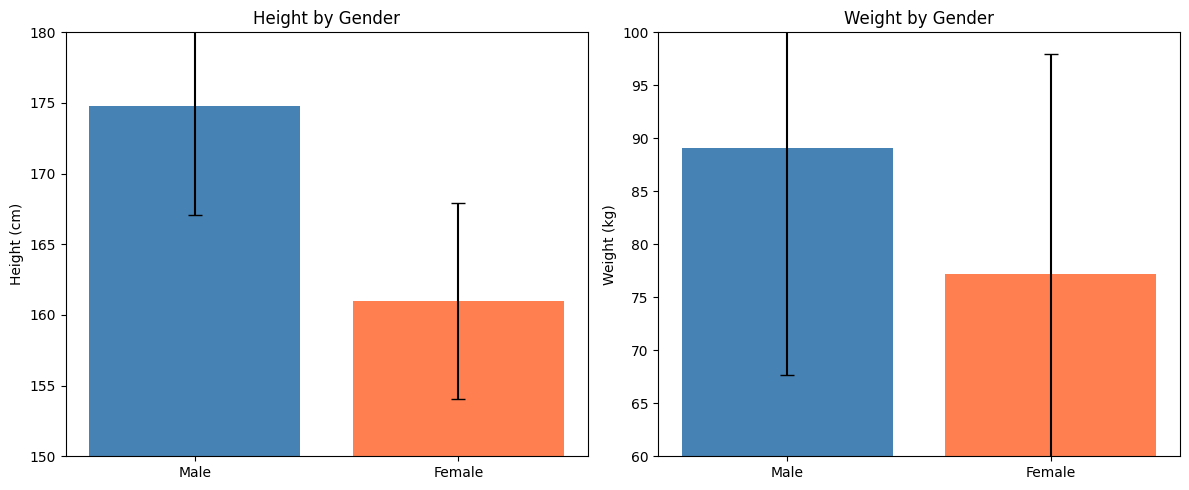

In [4]:
# Plot height/weight by gender
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

gender_data = by_variable.get("RIAGENDR", [])
genders = [g[0] for g in gender_data]
height_means = [g[1]["height_mean"] for g in gender_data]
height_stds = [g[1]["height_std"] for g in gender_data]
weight_means = [g[1]["weight_mean"] for g in gender_data]
weight_stds = [g[1]["weight_std"] for g in gender_data]

axes[0].bar(genders, height_means, yerr=height_stds, capsize=5, color=["steelblue", "coral"])
axes[0].set_ylabel("Height (cm)")
axes[0].set_title("Height by Gender")
axes[0].set_ylim(150, 180)

axes[1].bar(genders, weight_means, yerr=weight_stds, capsize=5, color=["steelblue", "coral"])
axes[1].set_ylabel("Weight (kg)")
axes[1].set_title("Weight by Gender")
axes[1].set_ylim(60, 100)

plt.tight_layout()
plt.show()

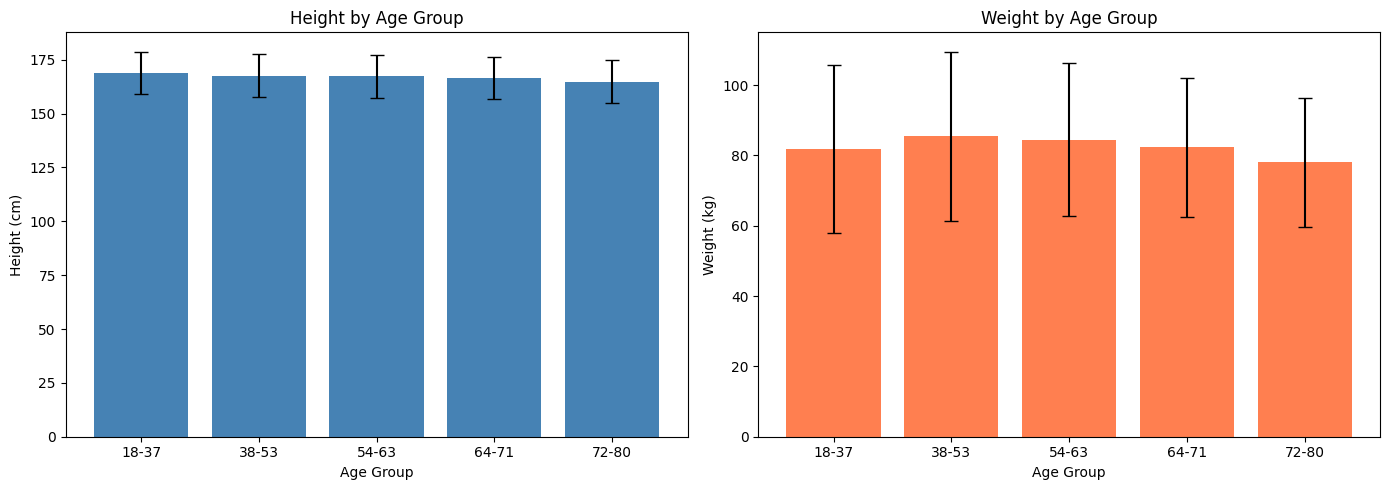

In [5]:
# Plot height/weight by age group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

age_data = by_variable.get("RIDAGEYR", [])
# Sort by age range
age_data_sorted = sorted(age_data, key=lambda x: int(x[0].split("-")[0]))

ages = [a[0] for a in age_data_sorted]
height_means = [a[1]["height_mean"] for a in age_data_sorted]
height_stds = [a[1]["height_std"] for a in age_data_sorted]
weight_means = [a[1]["weight_mean"] for a in age_data_sorted]
weight_stds = [a[1]["weight_std"] for a in age_data_sorted]

axes[0].bar(ages, height_means, yerr=height_stds, capsize=5, color="steelblue")
axes[0].set_ylabel("Height (cm)")
axes[0].set_xlabel("Age Group")
axes[0].set_title("Height by Age Group")

axes[1].bar(ages, weight_means, yerr=weight_stds, capsize=5, color="coral")
axes[1].set_ylabel("Weight (kg)")
axes[1].set_xlabel("Age Group")
axes[1].set_title("Weight by Age Group")

plt.tight_layout()
plt.show()

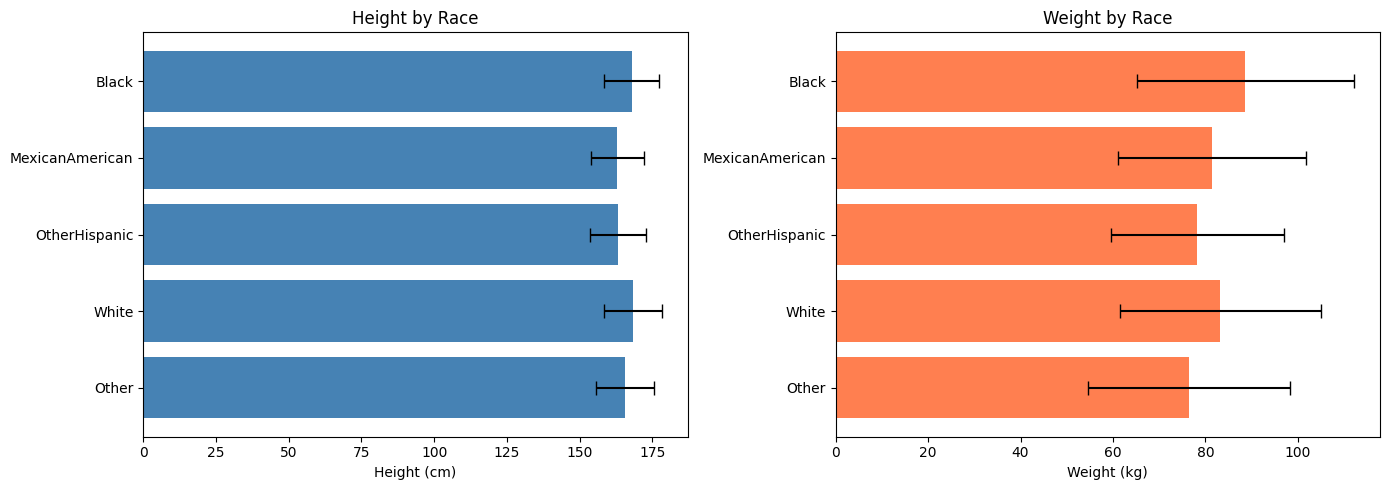

In [6]:
# Plot height/weight by race
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

race_data = by_variable.get("RIDRETH1", [])
races = [r[0] for r in race_data]
height_means = [r[1]["height_mean"] for r in race_data]
height_stds = [r[1]["height_std"] for r in race_data]
weight_means = [r[1]["weight_mean"] for r in race_data]
weight_stds = [r[1]["weight_std"] for r in race_data]

axes[0].barh(races, height_means, xerr=height_stds, capsize=5, color="steelblue")
axes[0].set_xlabel("Height (cm)")
axes[0].set_title("Height by Race")

axes[1].barh(races, weight_means, xerr=weight_stds, capsize=5, color="coral")
axes[1].set_xlabel("Weight (kg)")
axes[1].set_title("Weight by Race")

plt.tight_layout()
plt.show()

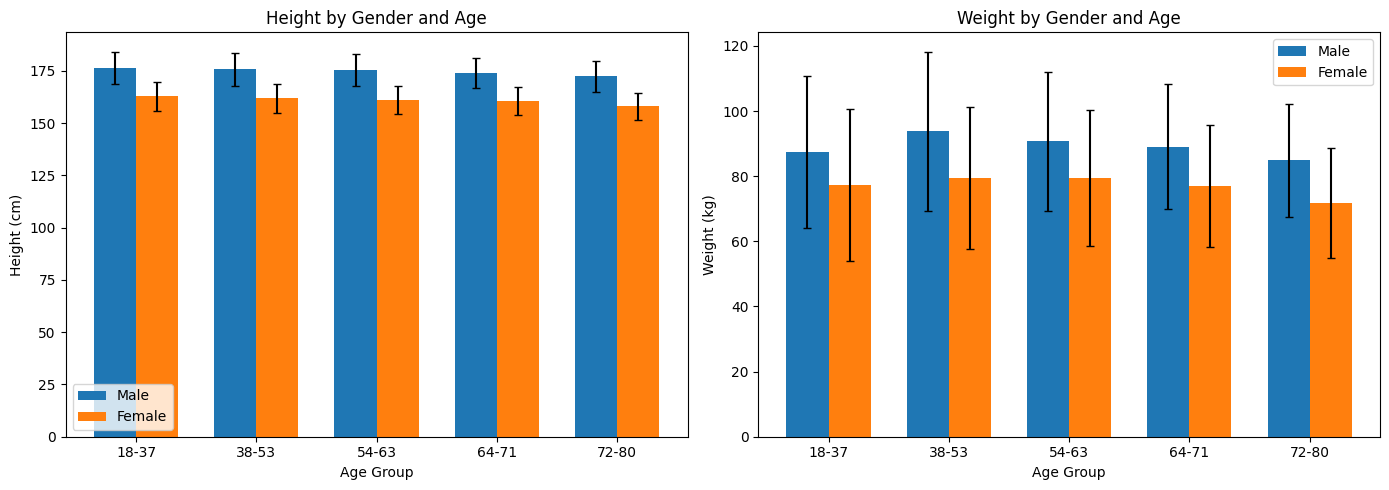

In [7]:
# Plot Gender x Age combinations
two_var_keys = entries_by_nvars.get(2, [])

# Filter for RIAGENDR x RIDAGEYR
gender_age_keys = [k for k in two_var_keys if "RIAGENDR" in k and "RIDAGEYR" in k]

# Organize data
male_data = {}
female_data = {}

for key in gender_age_keys:
    parsed = parse_key(key)
    gender = parsed["RIAGENDR"]
    age = parsed["RIDAGEYR"]
    stats = distributions[key]
    
    if gender == "Male":
        male_data[age] = stats
    else:
        female_data[age] = stats

# Sort ages
ages_sorted = sorted(male_data.keys(), key=lambda x: int(x.split("-")[0]))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(ages_sorted))
width = 0.35

# Height
male_heights = [male_data[a]["height_mean"] for a in ages_sorted]
female_heights = [female_data[a]["height_mean"] for a in ages_sorted]
male_h_std = [male_data[a]["height_std"] for a in ages_sorted]
female_h_std = [female_data[a]["height_std"] for a in ages_sorted]

axes[0].bar(x - width/2, male_heights, width, yerr=male_h_std, label="Male", capsize=3)
axes[0].bar(x + width/2, female_heights, width, yerr=female_h_std, label="Female", capsize=3)
axes[0].set_ylabel("Height (cm)")
axes[0].set_xlabel("Age Group")
axes[0].set_title("Height by Gender and Age")
axes[0].set_xticks(x)
axes[0].set_xticklabels(ages_sorted)
axes[0].legend()

# Weight
male_weights = [male_data[a]["weight_mean"] for a in ages_sorted]
female_weights = [female_data[a]["weight_mean"] for a in ages_sorted]
male_w_std = [male_data[a]["weight_std"] for a in ages_sorted]
female_w_std = [female_data[a]["weight_std"] for a in ages_sorted]

axes[1].bar(x - width/2, male_weights, width, yerr=male_w_std, label="Male", capsize=3)
axes[1].bar(x + width/2, female_weights, width, yerr=female_w_std, label="Female", capsize=3)
axes[1].set_ylabel("Weight (kg)")
axes[1].set_xlabel("Age Group")
axes[1].set_title("Weight by Gender and Age")
axes[1].set_xticks(x)
axes[1].set_xticklabels(ages_sorted)
axes[1].legend()

plt.tight_layout()
plt.show()

Gender x Age x Race combinations: 50


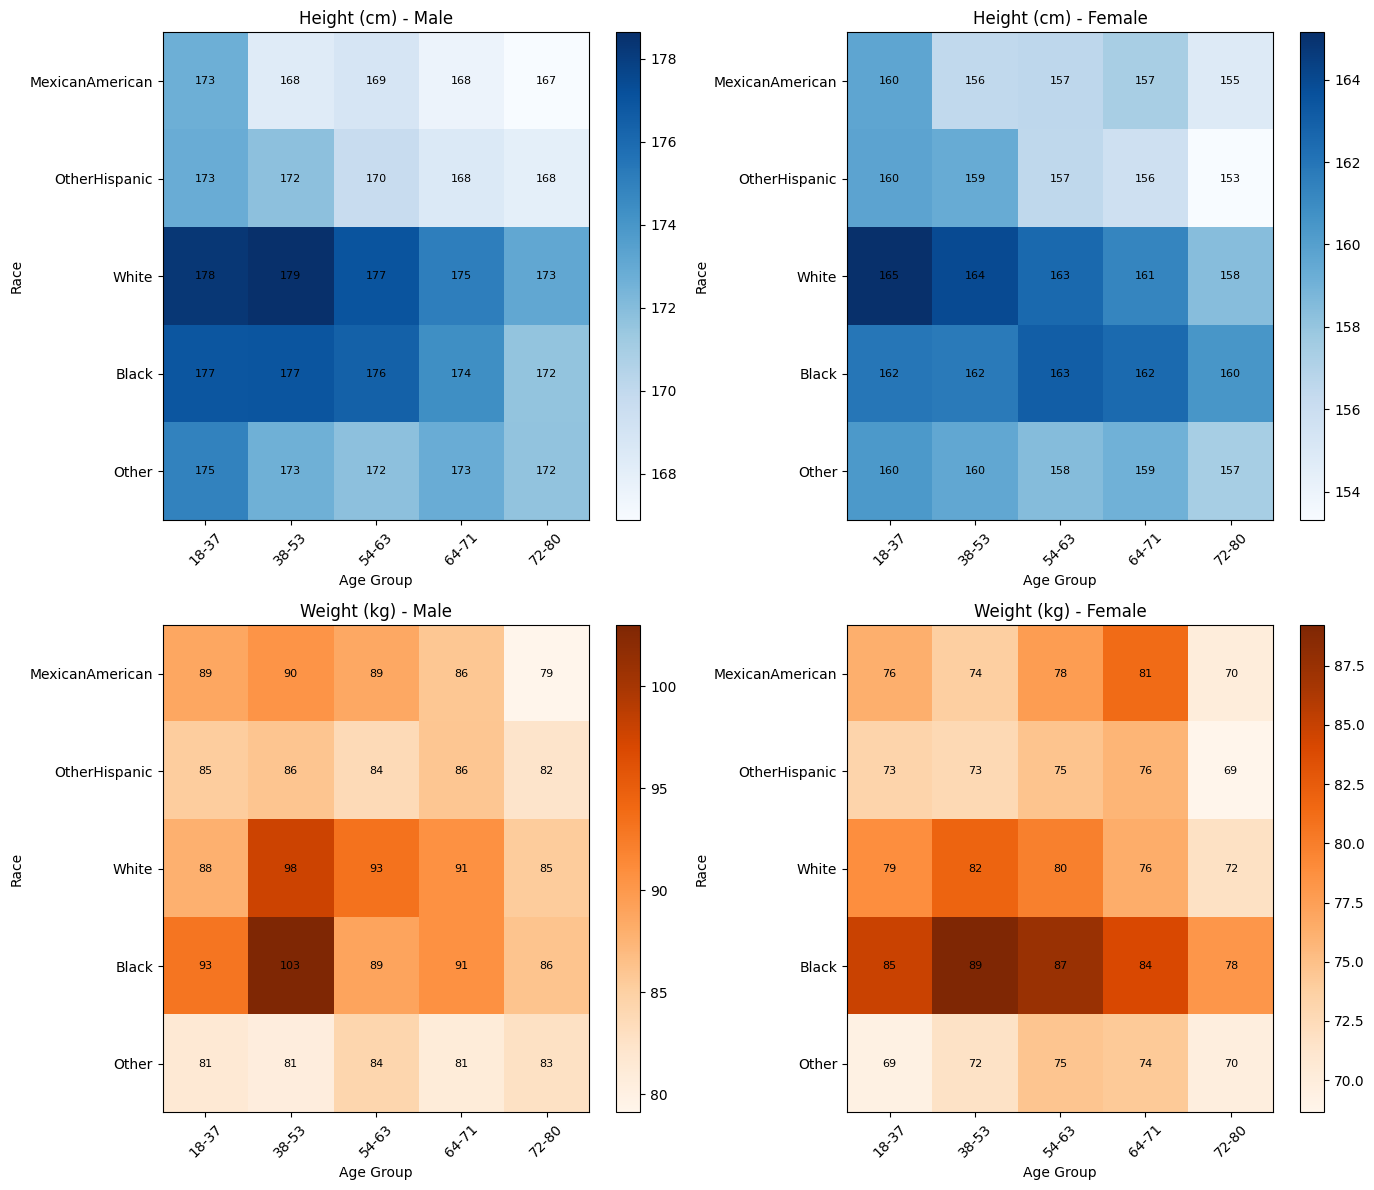

In [8]:
# Plot Gender x Age x Race (3 variable combinations)
three_var_keys = entries_by_nvars.get(3, [])

# Filter for specific combinations
gender_age_race_keys = [k for k in three_var_keys 
                        if "RIAGENDR" in k and "RIDAGEYR" in k and "RIDRETH1" in k]

print(f"Gender x Age x Race combinations: {len(gender_age_race_keys)}")

# Create heatmap data for height (Male)
races = list(metadata["variables"]["RIDRETH1"]["values"])
ages = sorted(set(parse_key(k)["RIDAGEYR"] for k in gender_age_race_keys), 
              key=lambda x: int(x.split("-")[0]))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, gender in enumerate(["Male", "Female"]):
    # Height heatmap
    height_matrix = np.full((len(races), len(ages)), np.nan)
    weight_matrix = np.full((len(races), len(ages)), np.nan)
    
    for key in gender_age_race_keys:
        parsed = parse_key(key)
        if parsed["RIAGENDR"] != gender:
            continue
        
        race_idx = races.index(parsed["RIDRETH1"]) if parsed["RIDRETH1"] in races else -1
        age_idx = ages.index(parsed["RIDAGEYR"]) if parsed["RIDAGEYR"] in ages else -1
        
        if race_idx >= 0 and age_idx >= 0:
            height_matrix[race_idx, age_idx] = distributions[key]["height_mean"]
            weight_matrix[race_idx, age_idx] = distributions[key]["weight_mean"]
    
    # Plot height
    im = axes[0, idx].imshow(height_matrix, cmap="Blues", aspect="auto")
    axes[0, idx].set_xticks(range(len(ages)))
    axes[0, idx].set_xticklabels(ages, rotation=45)
    axes[0, idx].set_yticks(range(len(races)))
    axes[0, idx].set_yticklabels(races)
    axes[0, idx].set_xlabel("Age Group")
    axes[0, idx].set_ylabel("Race")
    axes[0, idx].set_title(f"Height (cm) - {gender}")
    plt.colorbar(im, ax=axes[0, idx])
    
    # Add text annotations
    for i in range(len(races)):
        for j in range(len(ages)):
            if not np.isnan(height_matrix[i, j]):
                axes[0, idx].text(j, i, f"{height_matrix[i, j]:.0f}", 
                                  ha="center", va="center", fontsize=8)
    
    # Plot weight
    im = axes[1, idx].imshow(weight_matrix, cmap="Oranges", aspect="auto")
    axes[1, idx].set_xticks(range(len(ages)))
    axes[1, idx].set_xticklabels(ages, rotation=45)
    axes[1, idx].set_yticks(range(len(races)))
    axes[1, idx].set_yticklabels(races)
    axes[1, idx].set_xlabel("Age Group")
    axes[1, idx].set_ylabel("Race")
    axes[1, idx].set_title(f"Weight (kg) - {gender}")
    plt.colorbar(im, ax=axes[1, idx])
    
    for i in range(len(races)):
        for j in range(len(ages)):
            if not np.isnan(weight_matrix[i, j]):
                axes[1, idx].text(j, i, f"{weight_matrix[i, j]:.0f}", 
                                  ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

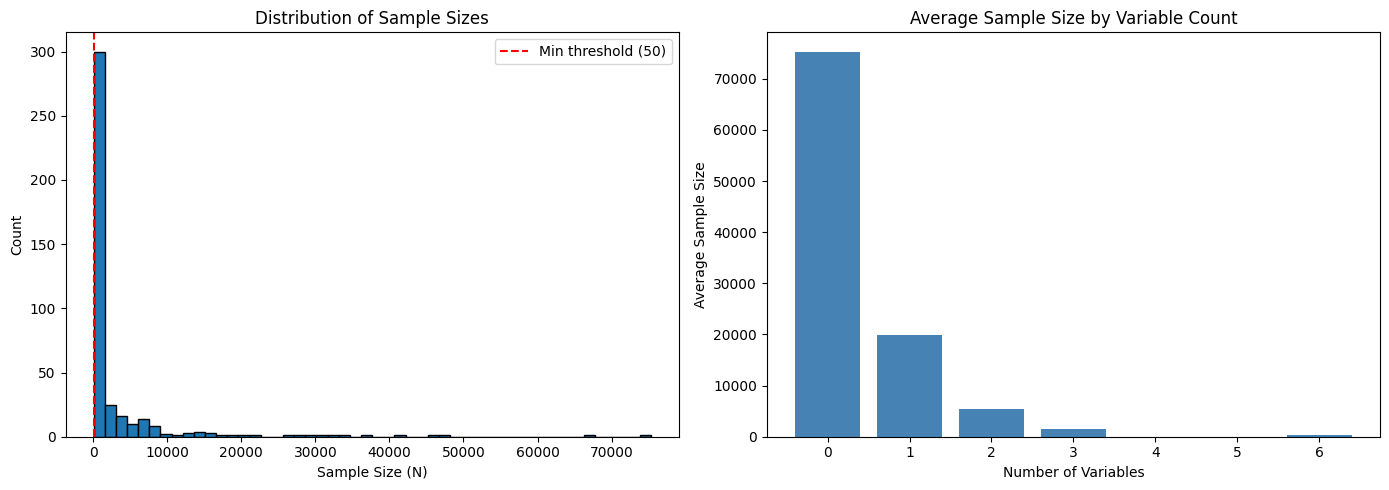

In [9]:
# Visualize sample size distribution
sample_sizes = [d["n"] for d in distributions.values()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(sample_sizes, bins=50, edgecolor="black")
axes[0].set_xlabel("Sample Size (N)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Sample Sizes")
axes[0].axvline(x=50, color="red", linestyle="--", label="Min threshold (50)")
axes[0].legend()

# Sample size by number of variables
avg_n_by_nvars = {}
for nvars, keys in entries_by_nvars.items():
    sizes = [distributions[k]["n"] for k in keys]
    avg_n_by_nvars[nvars] = np.mean(sizes)

axes[1].bar(list(avg_n_by_nvars.keys()), list(avg_n_by_nvars.values()), color="steelblue")
axes[1].set_xlabel("Number of Variables")
axes[1].set_ylabel("Average Sample Size")
axes[1].set_title("Average Sample Size by Variable Count")

plt.tight_layout()
plt.show()

/var/folders/22/jgvw68bn3f92bk_kk8t639xm0000gn/T/ipykernel_85446/810033042.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(height_data, labels=nvars_list)
/var/folders/22/jgvw68bn3f92bk_kk8t639xm0000gn/T/ipykernel_85446/810033042.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(weight_data, labels=nvars_list)


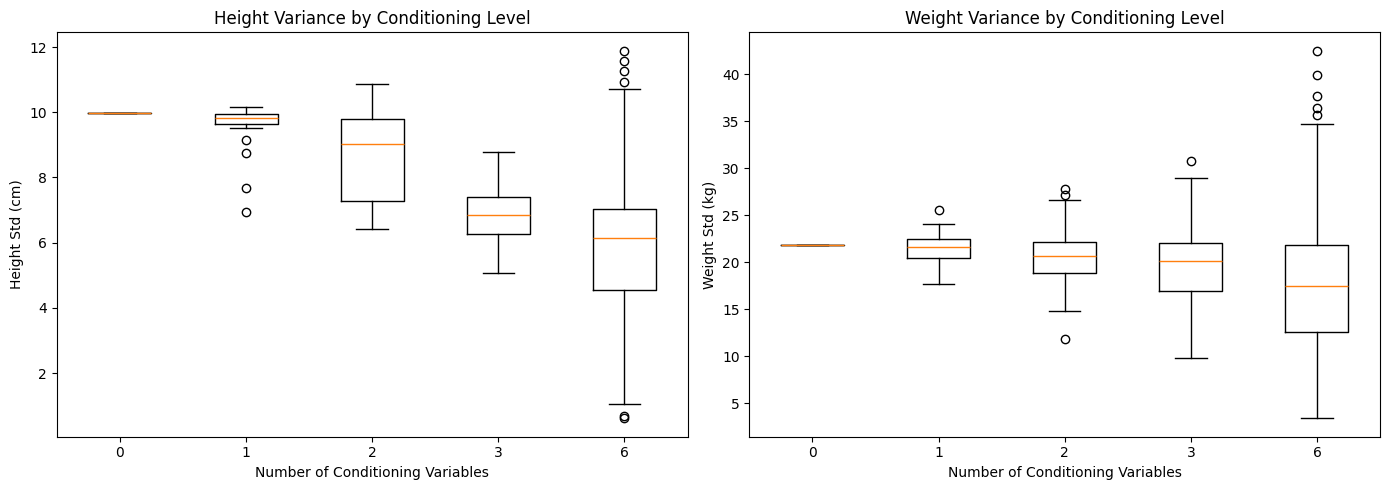

Average std by conditioning level:
  0 vars: Height std=9.99, Weight std=21.86
  1 vars: Height std=9.59, Weight std=21.55
  2 vars: Height std=8.58, Weight std=20.68
  3 vars: Height std=6.81, Weight std=19.92
  6 vars: Height std=5.98, Weight std=17.70


In [10]:
# Analyze variance across different conditioning variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Collect std by number of variables
height_stds_by_nvars = {}
weight_stds_by_nvars = {}

for nvars, keys in entries_by_nvars.items():
    height_stds_by_nvars[nvars] = [distributions[k]["height_std"] for k in keys]
    weight_stds_by_nvars[nvars] = [distributions[k]["weight_std"] for k in keys]

# Box plot for height std
nvars_list = sorted(height_stds_by_nvars.keys())
height_data = [height_stds_by_nvars[n] for n in nvars_list]
weight_data = [weight_stds_by_nvars[n] for n in nvars_list]

axes[0].boxplot(height_data, labels=nvars_list)
axes[0].set_xlabel("Number of Conditioning Variables")
axes[0].set_ylabel("Height Std (cm)")
axes[0].set_title("Height Variance by Conditioning Level")

axes[1].boxplot(weight_data, labels=nvars_list)
axes[1].set_xlabel("Number of Conditioning Variables")
axes[1].set_ylabel("Weight Std (kg)")
axes[1].set_title("Weight Variance by Conditioning Level")

plt.tight_layout()
plt.show()

print("Average std by conditioning level:")
for n in nvars_list:
    print(f"  {n} vars: Height std={np.mean(height_stds_by_nvars[n]):.2f}, Weight std={np.mean(weight_stds_by_nvars[n]):.2f}")